In [33]:
import torch
import yaml
from image_helper import ImageHelper
from datetime import datetime
import numpy as np
import pandas as pd

d = datetime.now().strftime('%b.%d_%H.%M.%S')

In [34]:
params_fp = "/Users/jpgard/Documents/github/differential-privacy-vs-fairness/utils/params_mnist_binary.yaml"

In [42]:
def make_mnist_dataset(majority_key, minority_key, params_fp=params_fp):
    with open(params_fp) as f:
        params = yaml.load(f)
    helper = ImageHelper(current_time=d, params=params, name='utk')
    classes_to_keep = [majority_key, minority_key]
    mu = helper.params['mu']

    helper.load_cifar_data(dataset=params['dataset'], classes_to_keep=classes_to_keep)
    helper.create_loaders()
    # Create a unique DataLoader for each class
    helper.sampler_per_class()

    helper.sampler_exponential_class(mu=mu, total_number=params['ds_size'], keys_to_drop=params['key_to_drop'],
                                    number_of_entries=params['number_of_entries'])
    helper.sampler_exponential_class_test(mu=mu, keys_to_drop=params['key_to_drop'],
          number_of_entries_test=params['number_of_entries_test'])

    # After sampling completes, we recode the data to majority/minority
#     if helper.params.get('binary_mnist_task'):
#         helper.recode_labels_to_binary(classes_to_keep)
    return helper

In [44]:
# helper = make_mnist_dataset(majority_key=2, minority_key=8)

In [45]:
# Define constants
gamma = helper.params['lr']
b = helper.params['batch_size']
s = 0. # No burn-in used
sigma_dp = 1.

# TODO(jpgard): verify all of these quantities; we should log this metric
# in the training loop so it is always available (could also compute with a
# randomly-initialized network).
L_w_0 = 3.0
L1_w_0 = 0.3  # Initial error at w_0 on the minority group
L1_w_star = 0.
L2_w_0 = 0.3 # Initial error at w_0 on the majority group
L2_w_star = 0.

In [46]:
def get_data_matrices(helper, minority_labels=[0,], majority_labels=[1,]):
    n = len(helper.train_dataset)
    X = helper.train_dataset.data.numpy()
    X = X.reshape(n, -1)
    minority_ix = np.isin(helper.train_dataset.targets.numpy(), minority_labels)
    majority_ix = np.isin(helper.train_dataset.targets.numpy(), majority_labels)
    assert (minority_ix.sum() > 0) and (majority_ix.sum() > 0)
    X_minority = X[minority_ix]
    X_majority = X[majority_ix]
    return X, X_minority, X_majority

In [47]:
# Computes the error bound, according to Conjecture
def compute_error_bound(H, H_subgroup, L_w_0, L_w_star, sigma_noise_squared, sigma_dp_squared, n):
    eigenvalues, eigenvectors = np.linalg.eig(H)
    mu = np.max(eigenvalues)
    print(f"mu: {mu}")
    H_inv = np.linalg.pinv(H)
    bias_term = float(2) / (gamma**2 * mu**2) * (1 - gamma * mu)**s / (float(n)/b - s)**2 * (L_w_0 - L_w_star)
    variance_term = 4 * np.trace(H_subgroup @ H_inv @ (sigma_noise_squared * H + sigma_dp_squared*np.eye(len(H))) @ H_inv) / (n - b * s)
    print(f"bias term {bias_term}; variance term {variance_term}")
    bound = float(bias_term + variance_term)
    return bound

In [48]:
# X, X_minority, X_majority = get_data_matrices(helper)
# n = len(X)
# H = np.cov(X, rowvar=False)
# H_minority = np.cov(X_minority, rowvar=False)
# H_majority = np.cov(X_majority, rowvar=False)

# minority_bound = compute_error_bound(H=H, H_subgroup=H_minority, L_w_0=L1_w_0, L_w_star=L1_w_star,
#                    sigma_noise_squared=0, sigma_dp_squared=sigma_dp**2, n=n)
# print("Computed bound for minority group: %s" % minority_bound)
# majority_bound = compute_error_bound(H=H, H_subgroup=H_majority, L_w_0=L2_w_0, L_w_star=L2_w_star,
#                    sigma_noise_squared=0, sigma_dp_squared=sigma_dp**2, n=n)
# print("Computed bound for majority group: %s" % majority_bound)

In [49]:
results = list()
minority_key = 8
for majority_key in (0,1,2,3,4,5,6,7,9):
    print("Evaluating classification {} vs {}".format(majority_key, minority_key))
    helper = make_mnist_dataset(majority_key=majority_key, minority_key=minority_key)
    X, X_minority, X_majority = get_data_matrices(helper, minority_labels=[minority_key,], 
                                                  majority_labels=[majority_key,])
    n = len(X)
    H = np.cov(X, rowvar=False)
    H_minority = np.cov(X_minority, rowvar=False)
    H_majority = np.cov(X_majority, rowvar=False)
    minority_bound = compute_error_bound(H=H, H_subgroup=H_minority, L_w_0=L1_w_0, L_w_star=L1_w_star,
                   sigma_noise_squared=0, sigma_dp_squared=sigma_dp**2, n=n)

    majority_bound = compute_error_bound(H=H, H_subgroup=H_majority, L_w_0=L2_w_0, L_w_star=L2_w_star,
                       sigma_noise_squared=1., sigma_dp_squared=sigma_dp**2, n=n)

    results.append((majority_key, minority_key, majority_bound, minority_bound))

Evaluating classification 0 vs 8
[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 11774
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 1954
[DEBUG] unique train labels: tensor([0., 8.])
[DEBUG] unique test labels: tensor([0., 8.])


/Users/jpgard/Documents/github/differential-privacy-vs-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


mu: (648462.2139273309+0j)
bias term (6.7454941294320686e-12+0j); variance term 0.6409565803083097


/Users/jpgard/Documents/github/differential-privacy-vs-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


mu: (648462.2139273309+0j)
bias term (6.7454941294320686e-12+0j); variance term 1.324103166770002
Evaluating classification 1 vs 8
[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 12593
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 2109
[DEBUG] unique train labels: tensor([1., 8.])
[DEBUG] unique test labels: tensor([1., 8.])
mu: (495237.5660573881+0j)
bias term (1.0109870980587353e-11+0j); variance term 56.38247416139139
mu: (495237.5660573881+0j)
bias term (1.0109870980587353e-11+0j); variance term 136.82084742839055
Evaluating classification 2 vs 8
[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 11809
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 2006
[DEBUG] unique train labels: tensor([2., 8.])
[DEBUG] unique test labels: tensor([2., 8.])
mu: (344898.47472497716+0j)
bias term (2.3704040925737252e-11+0j); variance term 1.0868417635416427
mu: (344898.47472497716+0j)

In [50]:
pd.DataFrame(results, columns=['majority', 'minority', 'majority_bound', 'minority_bound'])


,majority,minority,majority_bound,minority_bound
0,0,8,1.324103,0.640957
1,1,8,136.820847,56.382474
2,2,8,11.608379,1.086842
3,3,8,12.450716,51.426015
4,4,8,26.212526,2.300208
5,5,8,30.499296,8.845777
6,6,8,6.240480,1.425869
7,7,8,0.509497,2.256268
8,9,8,5.021490,4.603175


/Users/jpgard/Documents/github/differential-privacy-vs-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 12593
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 2109
[DEBUG] unique train labels: tensor([1., 8.])
[DEBUG] unique test labels: tensor([1., 8.])


Text(0.5, 1.0, 'H')

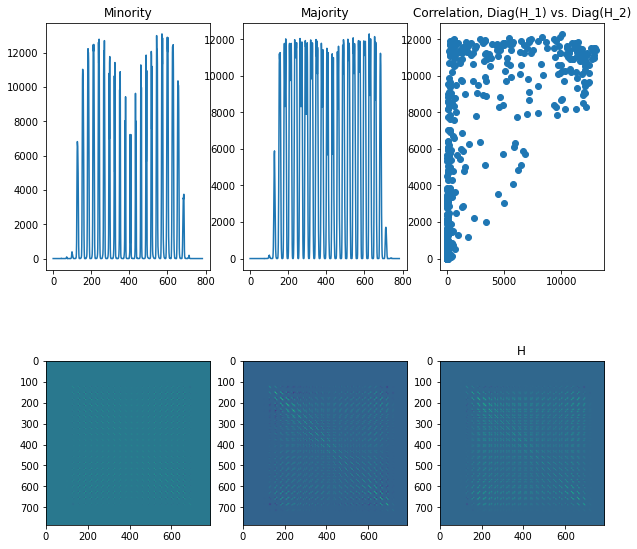

In [67]:
helper = make_mnist_dataset(majority_key=8, minority_key=1)
X, X_minority, X_majority = get_data_matrices(helper, minority_labels=[1,], 
                                                  majority_labels=[8,])
H = np.cov(X, rowvar=False)
H_minority = np.cov(X_minority, rowvar=False)
H_majority = np.cov(X_majority, rowvar=False)
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,10))
ax[0,0].plot(np.diag(H_minority))
ax[0,0].set_title("Minority")
ax[0,1].plot(np.diag(H_majority))
ax[0,1].set_title("Majority")
ax[0,2].scatter(np.diag(H_minority), np.diag(H_majority))
ax[0,2].set_title("Correlation, Diag(H_1) vs. Diag(H_2)")
# ax[1,1].plot(np.diag(H))
ax[1,0].imshow(H_minority)
ax[1,1].imshow(H_majority)
ax[1,2].imshow(H)
ax[1,2].set_title("H")

/Users/jpgard/Documents/github/differential-privacy-vs-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 11774
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 1954
[DEBUG] unique train labels: tensor([0., 8.])
[DEBUG] unique test labels: tensor([0., 8.])
index 0 at position [0,0]
[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 12593
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 2109
[DEBUG] unique train labels: tensor([1., 8.])
[DEBUG] unique test labels: tensor([1., 8.])
index 1 at position [0,1]
[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 11809
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 2006
[DEBUG] unique train labels: tensor([2., 8.])
[DEBUG] unique test labels: tensor([2., 8.])
index 2 at position [0,2]
[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 11982
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering 

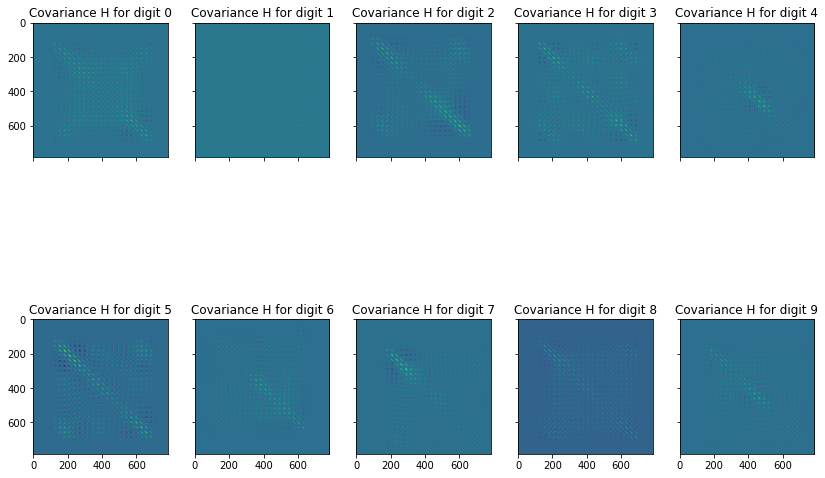

In [78]:
nrows=2
ncols=5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14,10), sharex=True, sharey=True)
min_val = 0
max_val = 0
for i in [0,1,2,3,4,5,6,7,9]:
    helper = make_mnist_dataset(majority_key=8, minority_key=i)
    _, X_minority, X_majority = get_data_matrices(helper, minority_labels=[i,], majority_labels=[8,])
    H_minority = np.cov(X_minority, rowvar=False)
    rownum = i // ncols
    colnum = i % ncols
    print(f"index {i} at position [{rownum},{colnum}]")
    ax[rownum, colnum].imshow(H_minority)
    ax[rownum, colnum].set_title(f"Covariance H for digit {i}")
    min_val = H_minority.min()
    max_val = H_minority.max()
H_majority = np.cov(X_majority, rowvar=False)
ax[1, 3].imshow(H_majority)
ax[1, 3].set_title(f"Covariance H for digit 8")
plt.colorbar()
min_val = H_majority.min()
max_val = H_majority.max()
print(f"min: {min_val}, max: {max_val}")


# MNIST Experimental Results - Simple Binary Task

In [52]:
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt

def read_and_concat_files(files_list):
    df_list = []
    for f in files_list:
        df = pd.read_csv(f)
        df.drop(columns='Wall time', inplace=True)
        df["filename"] = os.path.basename(f)
        df["uid"] = re.search('run-mnist-(.*)-tag.*' ,f).group(1)
        df_list.append(df)
    return pd.concat(df_list)

In [ ]:
results_dir = "./mnist-results"
figsize=(16,10)

In [ ]:
# Replicate fig 4d
noisy_mse_by_n_files = [os.path.join(results_dir, f) for f in os.listdir(results_dir)
                  if 'sigma10' in f 
                  and 'mse_per_class' in f]
nonoise_mse_by_n_files = [os.path.join(results_dir, f) for f in os.listdir(results_dir)
                  if re.search(".*-n\d+-nonoise-tag-mse", f)]
noisy_mse_by_n_df = read_and_concat_files(noisy_mse_by_n_files + nonoise_mse_by_n_files)
noisy_mse_by_n_df = noisy_mse_by_n_df[noisy_mse_by_n_df.Step == 59]
noisy_mse_by_n_df['n'] = noisy_mse_by_n_df['uid'].apply(
    lambda x: int(re.search("\d-vs-\d-n(\d+).*", x).group(1)))
noisy_mse_by_n_df['noise'] = noisy_mse_by_n_df['uid'].str.contains('nonoise')
noisy_mse_by_n_df.sort_values(by='n', inplace=True)
noisy_mse_by_n_df

In [ ]:

fig, ax = plt.subplots(figsize=figsize)
for key, grp in noisy_mse_by_n_df.groupby(['noise']):
    ax.plot(grp['n'], grp['Value'], label=key, marker='o')
ax.legend(title="Noise")
ax.set_title("MNIST Classification: 8 vs. 2 (Noise Sigma=10)\nCompare To Figure 5(d)")
ax.set_ylabel("MSE")
ax.set_xlabel("Minority Class (8) Size")
plt.show()

In [ ]:
# Replicate Fig 4, row 1, column 1: No clip + no noise
files = [os.path.join(results_dir, f) for f in os.listdir(results_dir) 
         if 'nonoise-withnorm' in f
        and 'tag-mse_per_class' in f]
noclip_nonoise_df = read_and_concat_files(files)
noclip_nonoise_df['label'] = noclip_nonoise_df['filename'].apply(
lambda x: re.search(".*tag-mse_per_class_class_(\d)\.csv", x).group(1))

In [ ]:
noclip_nonoise_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
for key, grp in noclip_nonoise_df.groupby(['label']):
    if key != '8':
        axs[0].plot(grp['Step'], grp['Value'], label=key, marker='o')
    else:
        for uid, df in grp.groupby(['uid']):
            uid_short = re.search("(\d-vs-\d).*", uid).group(1)
            axs[1].plot(df['Step'], df['Value'], label=uid_short, marker='o')
axs[0].legend(title="Label")
axs[0].set_title("No Clip + No Noise (Classes Excluding 8)\nCompare To Figure 4(a), Row 1, Column 1")
axs[0].set_ylabel("MSE")
axs[0].set_xlabel("Epochs")
axs[1].legend(title="UID")
axs[1].set_title("No Clip + No Noise (Class 8 Only)\nCompare To Figure 4(a), Row 1, Column 1")
axs[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# Replicate Fig 4, row 2, column 1: No clip + no noise gradient norm
files = [os.path.join(results_dir, f) for f in os.listdir(results_dir) 
         if 'nonoise-withnorm' in f
        and 'tag-norms' in f]
noclip_nonoise_norm_df = read_and_concat_files(files)
noclip_nonoise_norm_df['label'] = noclip_nonoise_norm_df['filename'].apply(
lambda x: re.search(".*tag-norms_class_(\d)\.csv", x).group(1))

In [ ]:
noclip_nonoise_norm_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
for key, grp in noclip_nonoise_norm_df.groupby(['label']):
    if key != '8':
        axs[0].plot(grp['Step'], grp['Value'], label=key, marker='o')
    else:
        for uid, df in grp.groupby(['uid']):
            uid_short = re.search("(\d-vs-\d).*", uid).group(1)
            axs[1].plot(df['Step'], df['Value'], label=uid_short, marker='o')
axs[0].legend(title="Label")
axs[0].set_title("No Clip + No Noise (Classes Excluding 8)\nCompare To Figure 4(a), Row 2, Column 1")
axs[0].set_ylabel("Norm")
axs[0].set_xlabel("Epochs")
axs[1].legend(title="UID")
axs[1].set_title("No Clip + No Noise (Class 8 Only)\nCompare To Figure 4(a), Row 2, Column 1")
axs[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# Replicate figure 4a, column 3, row 1: MSE of Noisy SGD
per_class_mse_files = [os.path.join(results_dir, f) for f in os.listdir(results_dir) 
                       if (not re.search(".*-n\d+-.*", f)) 
                       and ("mse_per_class" in f)
                      and not 'nonoise' in f]
assert len(per_class_mse_files) == len(set(per_class_mse_files)), "Duplicate files detected."
per_class_mse_df = read_and_concat_files(per_class_mse_files)
per_class_mse_df['label'] = per_class_mse_df['filename'].apply(
    lambda x: re.search(".*class_(\d)\.csv$", x).group(1))

In [ ]:
per_class_mse_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
for key, grp in per_class_mse_df.groupby(['label']):
    if key != '8':
        axs[0].plot(grp['Step'], grp['Value'], label=key, marker='o')
    else:
        for uid, df in grp.groupby(['uid']):
            axs[1].plot(df['Step'], df['Value'], label=uid, marker='o')
axs[0].legend(title="Label")
axs[0].set_title("No Clip + Noise (Classes Excluding 8)\nCompare To Figure 4(a), Top Row/Column 3")
axs[0].set_ylabel("MSE")
axs[0].set_xlabel("Epochs")

axs[1].set_title("No Clip + Noise (Class 8 Only)\nCompare To Figure 4(a), Top Row/Column 3")
axs[1].legend(title="UID")
axs[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# Replicate figure 4a, column 3, row 2: norm of Noisy SGD
per_class_norm_files = [os.path.join(results_dir, f) for f in os.listdir(results_dir) 
                       if (not re.search(".*-n\d+-.*", f)) 
                       and ("tag-norms" in f)]
assert len(per_class_norm_files) == len(set(per_class_norm_files)), "Duplicate files detected."
per_class_norm_df = read_and_concat_files(per_class_norm_files)
per_class_norm_df['label'] = per_class_norm_df['filename'].apply(
    lambda x: re.search(".*class_(\d)\.csv$", x).group(1))

In [ ]:
per_class_norm_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
for key, grp in per_class_norm_df.groupby(['label']):
    if key != '8':
        axs[0].plot(grp['Step'], grp['Value'], label=key, marker='o')
    else:
        for uid, df in grp.groupby(['uid']):
            axs[1].plot(df['Step'], df['Value'], label=uid, marker='o')
axs[0].legend(title="Label")
axs[0].set_title("No Clip + Noise (Classes Excluding 8)\nCompare To Figure 4(a), Bottom Row/Column 3")
axs[0].set_ylabel("Gradient norm")
axs[0].set_xlabel("Epochs")

axs[1].set_title("No Clip + Noise (Class 8 Only)\nCompare To Figure 4(a), Bottom Row/Column 3")
axs[1].legend(title="UID")
axs[1].set_xlabel("Epochs")
plt.show()

# Experimental

In [ ]:

noclip_nonoise_df['comparison'] = noclip_nonoise_df['uid'].apply(
lambda x: re.search(".*(\d-vs-\d).*",x).group(1))
noclip_nonoise_df

In [ ]:
per_class_mse_df.loc[(per_class_mse_df.label=='2') & (per_class_mse_df.Step==1)]
per_class_mse_df['comparison'] = per_class_mse_df['uid'].apply(
lambda x: re.search(".*(\d-vs-\d).*",x).group(1))
per_class_mse_df

In [ ]:
noclip_nonoise_df.merge(per_class_mse_df, on=['Step', 'comparison', 'label'])

In [ ]:
merged_df = noclip_nonoise_df.merge(per_class_mse_df, on=['Step', 'comparison', 'label'])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=figsize, sharey=True)
for key, grp in merged_df.groupby(['label']):
    if key != '8':
        axs[0].plot(grp['Step'], grp['Value_x'] - grp['Value_y'], label=key, marker='o')
    else:
        for uid, df in grp.groupby(['comparison']):
            axs[1].plot(df['Step'], df['Value_x'] - df['Value_y'], label=uid, marker='o')
axs[0].legend(title="Label")
axs[0].set_title("Classes Excluding 8")
axs[0].set_ylabel("MSE(no noise) - MSE(noise)")
axs[0].set_xlabel("Epochs")

axs[1].set_title("Class 8 Only")
axs[1].legend(title="UID")
axs[1].set_xlabel("Epochs")
plt.show()

# MNIST Experimental Results - Grouped Binary Task (1,7 vs. 3,8)

In [ ]:
results_dir_v2 = "/Users/jpgard/Documents/github/differential-privacy-vs-fairness/mnist-results-v2"
mse_files = [os.path.join(results_dir_v2, f) for f in os.listdir(results_dir_v2) if "mse_per_class" in f]
grouped_mse_df = read_and_concat_files(mse_files)
grouped_mse_df['label'] = grouped_mse_df['filename'].apply(
    lambda x: re.search(".*class_(\d)\.csv$", x).group(1))
grouped_mse_df['n'] = grouped_mse_df['uid'].apply(
    lambda x: re.search(".*-n(\d+)$", x).group(1))

In [ ]:
grouped_mse_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize, sharey=True, sharex=True)
for i,label in enumerate(['1', '7', '3', '8']):
    row = i // 2
    col = i % 2
    grp = grouped_mse_df[grouped_mse_df['label'] == label]
    axs[row,col].set_title(f"Test MSE for Class {label}")
    for uid, df in grp.groupby(['uid']):
        axs[row, col].plot(df['Step'], df['Value'], label=uid, marker='o')
        axs[row, col].set_xlabel("Epochs")
        axs[row, col].set_ylabel(f"MSE for class {label}")
        y = df[df['Step'] == 59]["Value"]
        n = df.loc[df['Step'] == 59, "n"]
        if col == 0:
            axs[row,col].text(59, y, "n = {}".format(n.iloc[0,]), size='large')
plt.show()

In [ ]:
norm_files = [os.path.join(results_dir_v2, f) for f in os.listdir(results_dir_v2) if "norms_class" in f]
grouped_norm_df = read_and_concat_files(norm_files)
grouped_norm_df['label'] = grouped_norm_df['filename'].apply(
    lambda x: re.search(".*class_(\d)\.csv$", x).group(1))
grouped_norm_df['n'] = grouped_norm_df['uid'].apply(
    lambda x: re.search(".*-n(\d+)$", x).group(1))

In [ ]:
grouped_norm_df.head()

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=figsize, sharey=True, sharex=True)
for i,label in enumerate(['1', '7', '3', '8']):
    row = i // 2
    col = i % 2
    grp = grouped_norm_df[grouped_norm_df['label'] == label]
    axs[row,col].set_title(f"Avg Gradient Norm for Class {label}")
    for uid, df in grp.groupby(['uid']):
        axs[row, col].plot(df['Step'], df['Value'], label=uid, marker='o')
        axs[row, col].set_xlabel("Epochs")
        axs[row, col].set_ylabel(f"Avg Grad Norm for class {label}")
        y = df[df['Step'] == 59]["Value"]
        n = df.loc[df['Step'] == 59, "n"]
        if col == 0:
            axs[row,col].text(59, y, "n = {}".format(n.iloc[0,]), size='large')
plt.show()

In [15]:
grouped_params_fp = "/Users/jpgard/Documents/github/differential-privacy-vs-fairness/utils/params_mnist_grouped.yaml"
def make_grouped_mnist_dataset(positive_class_keys, negative_class_keys, params_fp=grouped_params_fp):
    with open(params_fp) as f:
        params = yaml.load(f)
    helper = ImageHelper(current_time=d, params=params, name='utk')
    classes_to_keep = positive_class_keys + negative_class_keys
    mu = helper.params['mu']

    helper.load_cifar_data(dataset=params['dataset'], classes_to_keep=classes_to_keep)
    helper.create_loaders()
    # Create a unique DataLoader for each class
    helper.sampler_per_class()

    helper.sampler_exponential_class(mu=mu, total_number=params['ds_size'], keys_to_drop=params['key_to_drop'],
                                    number_of_entries=params['number_of_entries'])
    helper.sampler_exponential_class_test(mu=mu, keys_to_drop=params['key_to_drop'],
          number_of_entries_test=params['number_of_entries_test'])
    return helper

In [16]:
def get_grouped_data_matrices(helper, minority_labels=[0,], majority_labels=[1,]):
#     n = len(helper.train_dataset)
    X = helper.train_dataset.data.numpy()
    X = X.reshape(n, -1)
    minority_ix = np.isin(helper.train_dataset.targets.numpy(), minority_labels)
    majority_ix = np.isin(helper.train_dataset.targets.numpy(), majority_labels)
    assert (minority_ix.sum() > 0) and (majority_ix.sum() > 0)
    X_minority = X[minority_ix]
    X_majority = X[majority_ix]
    return X, X_minority, X_majority

In [32]:
# Bounds for the grouped data
results = list()
positive_class_keys = [3,8]
negative_class_keys = [1,7]
helper = make_grouped_mnist_dataset(positive_class_keys, negative_class_keys)
X, X_pos, X_neg = get_data_matrices(helper, positive_class_keys, negative_class_keys)
n = len(X)
H = np.cov(X, rowvar=False)
H_pos = np.cov(X_pos, rowvar=False)
H_neg = np.cov(X_neg, rowvar=False)
pos_bound = compute_error_bound(H=H, H_subgroup=H_pos, L_w_0=L1_w_0, L_w_star=L1_w_star,
               sigma_noise_squared=0, sigma_dp_squared=sigma_dp**2, n=n)

neg_bound = compute_error_bound(H=H, H_subgroup=H_neg, L_w_0=L2_w_0, L_w_star=L2_w_star,
                   sigma_noise_squared=1., sigma_dp_squared=sigma_dp**2, n=n)
print(f"Positive group bound for labels {positive_class_keys} is {pos_bound}")
print(f"Negative group bound for labels {negative_class_keys} is {neg_bound}")

/Users/jpgard/Documents/github/differential-privacy-vs-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  after removing the cwd from sys.path.


[DEBUG] train data start size: 60000
[DEBUG] train data after filtering size: 24989
[DEBUG] test data start size: 10000
[DEBUG] test data after filtering size: 4147
[DEBUG] unique train labels: tensor([1., 3., 7., 8.])
[DEBUG] unique test labels: tensor([1., 3., 7., 8.])
mu: (359993.8388305206+0j)
bias term (4.858959630516423e-12+0j); variance term 1.3356327640921446


/Users/jpgard/Documents/github/differential-privacy-vs-fairness/venv/lib/python3.6/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


mu: (359993.8388305206+0j)
bias term (4.858959630516423e-12+0j); variance term 0.9181823590266057
Positive group bound for labels [3, 8] is 1.3356327640970036
Negative group bound for labels [1, 7] is 0.9181823590314647


24989